In [1]:
import torch
from math import pi,sqrt,log,e,exp
from time import time
from matplotlib import pyplot
import numpy as np
from matplotlib import pyplot as plt
from tqdm.autonotebook import tqdm
dtype = torch.float
device = torch.device("cuda:4")

from src.models.flows.coupling_cells.real_nvp import RealNVP
from src.models.flows.sampling import FactorizedFlowPrior
from src.models.flows.analytic_flows.element_wise import AnalyticSigmoid,AnalyticInverseSigmoid

In [2]:
prior_mu =  torch.tensor(0.).to(device)
prior_sig =  torch.tensor(1.2).to(device)
prior = torch.distributions.normal.Normal(prior_mu,prior_sig)

sampler = FactorizedFlowPrior(d=2,prior_1d=prior)

sig = AnalyticSigmoid(d=2)
asig = AnalyticInverseSigmoid(d=2)

In [3]:
npoints = 100000
points = torch.zeros(npoints,3).to(device).uniform_()
points[:,-1]=0.

In [4]:
def f(x):
    return x[:,0]**2+x[:,1]

In [5]:
fs = f(points)

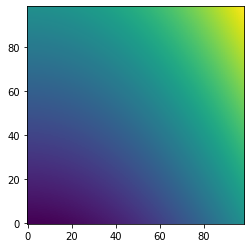

In [6]:
xy = torch.zeros(99,99).to(device)
for i in range(99):
    for j in range(99):
        xy[i,j] = f(torch.tensor(
        [[(i+1)/100.,(j+1)/100.]]
        ))

plt.imshow(xy.cpu().numpy().T,origin="lower")

In [8]:
try:
    del nvps
except:
    pass
nvps = [
        RealNVP(d=2,
              mask=[True,False],
              d_hidden=512,
              n_hidden=8,).to(device),
        RealNVP(d=2,
              mask=[False,True],
              d_hidden=8,
              n_hidden=512,).to(device),
        RealNVP(d=2,
              mask=[True,False],
              d_hidden=512,
              n_hidden=8,).to(device),
        RealNVP(d=2,
              mask=[False,True],
              d_hidden=8,
              n_hidden=512,).to(device),  
]

for n in nvps:
    n.invert()
nvps.reverse()

optim=torch.optim.Adam(sum([list(n.parameters()) for n in nvps],[]),lr=1.e-5)

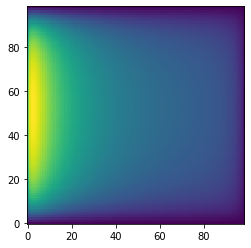

In [9]:
xy = torch.zeros(99,99,3).to(device)
for i in range(99):
    for j in range(99):
        xy[i,j,0] = (i+1)/100.
        xy[i,j,1] = (j+1)/100.
        xy[i,j,2] = 1
        
xy = asig(xy)
with torch.no_grad():
    for nn in nvps:
        xy = nn(xy)

p = xy[...,-1] +torch.sum(sampler.prior.log_prob(xy[...,:-1]),axis=-1)
plt.imshow((torch.exp(p)).cpu().numpy().T,origin="lower",interpolation="none")

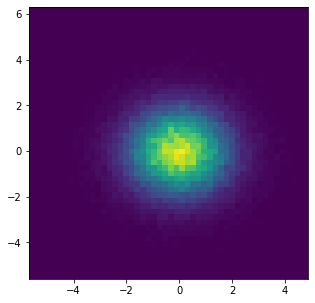

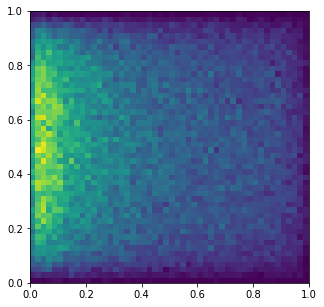

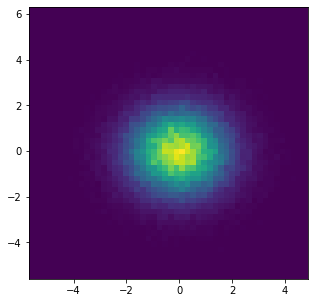

In [16]:
xx = sampler(100000)

plt.figure(figsize=(5,5))
h1=plt.hist2d(xx[:,0].cpu().numpy(),xx[:,1].cpu().numpy(),bins=50)
plt.show()


for n in nvps:
    n.invert()
nvps.reverse()
with torch.no_grad():
    for nvp in nvps:
        xx=nvp(xx)
    xx=sig(xx).cpu().numpy()
    plt.figure(figsize=(5,5))
    plt.hist2d(xx[:,0],xx[:,1],range=((0,1),(0,1)),bins=50)
    plt.show()
for nn in nvps:
    nn.invert()
nvps.reverse()

with torch.no_grad():
    xx=torch.tensor(xx).to(device)
    xx=asig(xx)
    for nvp in nvps:
        xx=nvp(xx)
plt.figure(figsize=(5,5))
h2=plt.hist2d(xx[:,0].cpu().numpy(),xx[:,1].cpu().numpy(),bins=50)
plt.show()